#Import Libraries

In [1]:
import theano
import theano.tensor as T
from theano import pp
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.stats import norm
from __future__ import division #this is important!!! otherwise, dividing will round
from collections import OrderedDict
%matplotlib inline

#Copy Carlos's code so that it works in Python

In [2]:
global epsilon


In [3]:
def make_bins(B,dx):
    '''
    inputs:
    -------
    - B is the value of the accumulator's sticky bound
    - dx is the spacing between all bins, except the first and last 
    - binN is the number of bins with bin centers > 0
    
    outputs:
    --------
    - bin_centers array of bin_centers
    - binN the number of bins with positive centers 
    '''
    binN = np.ceil(B/dx)
    
    bins = np.arange(1,binN+1)*B
    bins = dx*bins/B
    bins[-1] = B + dx if bins[-1] == B else 2*B - bins[-2]
    
    bins = np.append(np.append(-bins[np.arange(-1,-1-len(bins),-1)], 0), bins)  
    
    return bins, binN
    

In [8]:
def Fmatrix(pd,bin_centers,sigma_sbin,dt):
    '''
    inputs:
    -------
    - pd ditionary of parameters expected to contain the following keys
        - sigma,
        - lam
        - c
    - bins an array of bin centers created by make_bins
    - sigma_sbin
    outputs:
    --------
    - F square Markov matrix of transition probabilities
    '''
    sigma = pd['sigma']
    lam   = pd['lam']
    c     = pd['c']
    
    # in the julia implementation, F had to be multiplied by 0.0*sigma, 
    # we'll see if we need to do that here, but will start without doing that
    F = np.zeros([len(bin_centers),len(bin_centers)]) 
    
    # is this a good idea???
    # doesn't the fitter need to be able to chose lam = 0
    mus      = (bin_centers + c/lam)*np.exp(lam*dt) - c/lam 
    sbinsize = 0.1*np.sqrt(sigma_sbin**2 * dt)
    swidth   = 4*np.sqrt((sigma_sbin/dx)**2*dt)
    sbins    = np.arange(-swidth,swidth+epsilon, sbinsize)
    ps       = np.exp(-sbins**2 / (2*sigma**2*dt)) / np.sqrt(2*sigma**2*dt)
    ps       = ps/np.sum(ps);

    base_sbins = sbins;
    print len(base_sbins)
    for j in range(len(bin_centers)):
        sbins = np.array(range(len(base_sbins)),dtype=float)*sbinsize #collect(0:(length(base_sbins)-1))*sbinsize

        sbins = sbins + mus[j] - swidth
        #print sbins
        for k in range(len(sbins)):
            if sbins[k] < (bin_centers[0] + bin_centers[1])/2 :
                F[0,j] += ps[k]
            elif (bin_centers[-1]+bin_centers[-2])/2 <= sbins[k] :
                F[-1,j] += ps[k]
            else:
                # carlos was using a .<= in the following line,
                # I'm not sure what's special about that!
                bot = np.where(bin_centers <= sbins[k])[0][-1]
                top = bot+1
                #print 'bottom:', bot, 'top:', top
                F[bot,j] = F[bot,j] + ps[k]*(bin_centers[top] - sbins[k])/(bin_centers[top] - bin_centers[bot])
                F[top,j] = F[top,j] + ps[k]*(sbins[k] - bin_centers[bot])/(bin_centers[top] - bin_centers[bot])

    F[:,0] = 0; F[:,-1] = 0; F[0,0] = 1; F[-1,-1] = 1;
    return F

In [5]:
def probRight(pd,dt,dx,c):
    '''
    returns probability that the agent chose right
    '''
    # these are all globals in carlos's code
    #dt = .02; 
    c_trace = []; bin_centers = []; binN = []; a_trace = [];
    Nsteps = len(c)
    sigma_sbin = pd['sigma_a']; 
    sigma_a    = pd['sigma_a']*np.sqrt(dt)/dx
    sigma_s    = pd['sigma_s']
    sigma_i    = pd['sigma_i']
    bias       = pd['bias']
    B          = pd['B']
    lam        = pd['lam']
    phi        = pd['phi']
    tau_phi    = pd['tau_phi']
    lapse      = pd['lapse']
    
   
    bin_centers, binN = make_bins(B,dx)
    
    binBias = bias // dx + binN+1;
    
    a_trace = np.zeros([len(bin_centers), Nsteps]);  
    c_trace = np.zeros(Nsteps)

    a       = np.zeros(len(bin_centers)) 
    a[binN] = 1; # this line exists in the outer level of carlos's code, but seems to be immediately written over??
    a[binN] = 1-2*lapse
    a[0]    = lapse
    a[-1]   = lapse
    c_eff   = 1
    
    Fi = Fmatrix({'sigma':sigma_i/dx, 'lam':lam, 'c':0}, bin_centers, sigma_sbin, dt)
    a = np.dot(Fi, a) 
    a_trace[:,0] = a
    F0  = Fmatrix({'sigma':sigma_a, 'lam':lam, 'c':0}, bin_centers, sigma_sbin, dt)
    
    for step in range(int(Nsteps)-1):
        c_eff = 1 + (c_eff - 1)*np.exp(-dt/tau_phi)
        c_trace[step] = c_eff
        if c[step]==0:
            a = np.dot(F0,a) 
        else: 
            F = Fmatrix({'sigma':sigma_a, 'lam':lam, 'c':c_eff/dt},bin_centers, sigma_sbin, dt) 
            a = np.dot(F,a) 
            c_eff = c_eff*phi
        a_trace[:,step+1] = a

    pright = np.sum(a[binBias:]) + a[binBias-1]*0.5*(dx/2 - (bias - bin_centers[binBias-1]))/(dx/2)
    return pright, a_trace

In [6]:
epsilon = 10e-10; dx =.25; dt = .02; Nsteps = np.ceil(1/dt); 
pd = {'sigma':1, 'lam':-.5, 'c':1, 'sigma_a':1, 'sigma_s':0, 'sigma_i':0.5, 
      'bias':0, 'B': 4,'lapse':0.05, 'tau_phi':0.2, 'phi':0.3, }
sigma_sbin = pd['sigma_a']
c = np.zeros(Nsteps); c[[np.ceil(0.08/dt), np.ceil(0.4/dt)]] = 1;

#Try something simple

In [10]:
x = T.dscalar('x')
y = x ** 2
gy = T.grad(y,x)
pp(gy)

'((fill((x ** TensorConstant{2}), TensorConstant{1.0}) * TensorConstant{2}) * (x ** (TensorConstant{2} - TensorConstant{1})))'

In [26]:
f = theano.function([x], gy)
pp(f.maker.fgraph.outputs[0])

'(TensorConstant{2.0} * x)'

In [28]:
[f(a) for a in [1, 5, 10, 11]]

[array(2.0), array(10.0), array(20.0), array(22.0)]

## Okay, let's try something a bit more complicated

In [82]:
x = T.dscalar('x')
s = (1 / (1 + T.exp(-x)))
gs = T.grad(s, x)
dlogistic = theano.function([x], gs)


here's the function

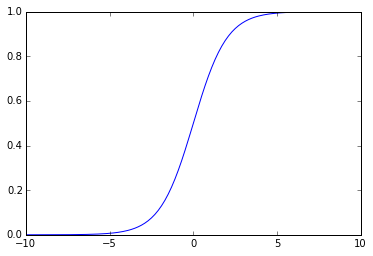

In [52]:
x = np.arange(-10,10,.1)
y = [1/(1+np.exp(-this_x)) for this_x in x]
plt.plot(x,y)

and here's its gradient

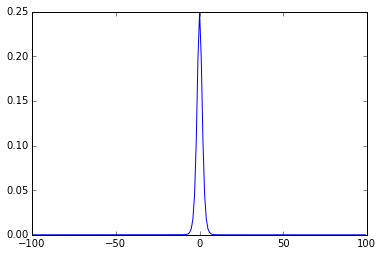

In [86]:
x_vals = np.arange(-100,100)
dsdx = [dlogistic(a).sum() for a in x_vals]
plt.plot(x_vals, dsdx)

## even more so?

instead of dscalar, we'll use dmatrix--the matrix type for doubles

In [196]:
x = T.dmatrix('x')
s = T.sum(1 / (1 + T.exp(-x)))
gs = T.grad(s, x)
dlogistic = theano.function([x], gs)

In [211]:
dlogistic([[1,5], [-10, -10], [0,100]])

array([[  1.96611933e-01,   6.64805667e-03],
       [  4.53958077e-05,   4.53958077e-05],
       [  2.50000000e-01,   3.72007598e-44]])

In [222]:
x0 = np.arange(100,-101,-1)
x1 = np.arange(-100,101)
x_vals = np.array([[a,b] for a in x0 for b in x1])
dsdx = dlogistic(x_vals)

derivative w.r.t x0

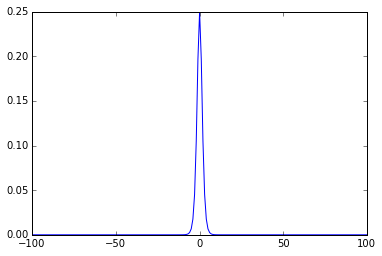

In [233]:
plt.plot(x_vals[:,0],dsdx[:,0])

derivative w.r.t x1

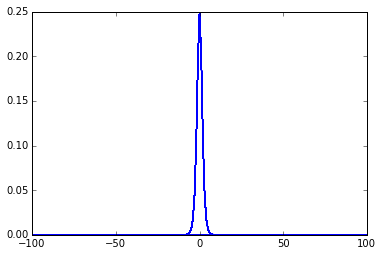

In [235]:
plt.plot(x_vals[:,1],dsdx[:,1])

#Close to Fokker-Planck

### First, I will play with numerical methods

In [44]:
stepsize=.1
eta = 1 #should be a random draw from a gaussian mu = 1 and sigma = sensory noise
timepoints = np.arange(0,10,stepsize)
lam = 0.1
diffusion_noise = 0
dw = 0
L = np.zeros(np.shape(timepoints))
R = np.zeros(np.shape(timepoints))
a = np.zeros(np.shape(timepoints))
c = np.zeros(np.shape(timepoints))
C = np.ones(np.shape(timepoints))
L[[1, 5, 15, 70, 75]] = 1 # should generate these from a poisson
R[[20, 25, 30, 50, 99]] = 1

In [37]:
def da(t,lam,a,c,stepsize,sigma,dw):
    # note: should probably just calculate click difference elsewhere 
    # and then put the noise in here, if we want to fit that parameter
    return (lam*a[t-1]+c[t])*stepsize + sigma*dw
def get_c(t,R,L,eta,C):
    return eta*C[t]*(R[t]-L[t])
def mu_ak(t,lam,a,stepsize,c):
    return np.exp(l*stepsize)*(a(t-1)+c[t]/lam)-c[t]/lam

        

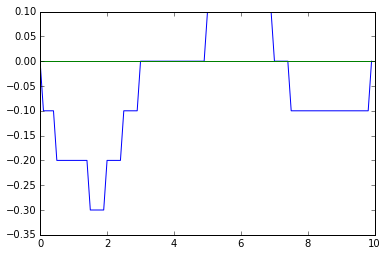

In [38]:

for t in np.arange(1,len(timepoints)):
    c[t] = get_c(t,R,L,eta,C)
    a[t] = a[t-1] + da(t,lam,a,c,stepsize,diffusion_noise,dw)
plt.plot(timepoints,a)
plt.plot([0, 10],[0, 0])

    

In [39]:
np.arange(1,10)


array([1, 2, 3, 4, 5, 6, 7, 8, 9])

In [45]:
#np.exp(lam*stepsize)*(a+c/lam)-c/lam
np.exp(lam*stepsize) 
c[1]/lam#*(c[1]/lam)#-c[1]/lam

0.0

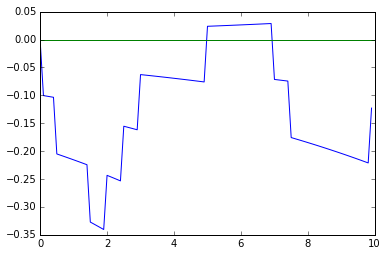

In [47]:
def a_update(a, lam, stepsize, c):
    return np.exp(lam*stepsize)*(a+c/lam)-c/lam

for t in np.arange(1,len(timepoints)):
    c[t] = get_c(t,R,L,eta,C)
    a[t] = a_update(a[t-1],lam,stepsize,c[t])
    
plt.plot(timepoints,a)
plt.plot(hold=True)
plt.plot([0, 10],[0, 0])

#don't want to use this form of the equation, because it is undefined for lambda = 0

${\sum_{k=1}^N \int P(a_k,a_{k-1}|d,\theta) \frac{d}{d\theta}lnP(a_k|a_{k-1},\theta)da_k da_{k-1}}$

#Discretization routine

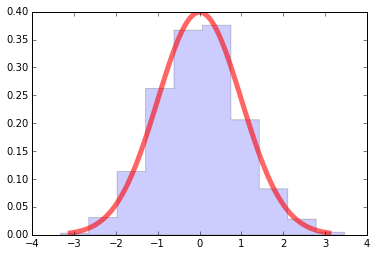

In [279]:
x = np.linspace(norm.ppf(0.001),
                 norm.ppf(0.999), 100)
y = norm.pdf(x)
r = norm.rvs(size=1000)
fig, ax = plt.subplots(1, 1)
mean, var, skew, kurt = norm.stats(moments='mvsk')
x = np.linspace(norm.ppf(0.001),
                 norm.ppf(0.999), 100)

ax.plot(x, y,'r-', lw=5, alpha=0.6, label='norm pdf')
_, bins, _ = ax.hist(r, normed=True, histtype='stepfilled', alpha=0.2)


In [ ]:
def jjdiscretize(y,bincenters):
    F1

In [361]:
x = T.dscalar('x')
s = T.dscalar('s')
y = 1/(s*np.pi)**.5*T.exp(-x ** 2)
gy = T.grad(y,x)
pp(gy)

'(((-((fill(((TensorConstant{1} / ((s * TensorConstant{3.14159265359}) ** TensorConstant{0.5})) * exp((-(x ** TensorConstant{2})))), TensorConstant{1.0}) * (TensorConstant{1} / ((s * TensorConstant{3.14159265359}) ** TensorConstant{0.5}))) * exp((-(x ** TensorConstant{2}))))) * TensorConstant{2}) * (x ** (TensorConstant{2} - TensorConstant{1})))'

In [363]:
f = theano.function([x,s], gy)
pp(f.maker.fgraph.outputs[0])

'Elemwise{Composite{((i0 * exp((-sqr(i1))) * i1) / sqrt((i2 * i3)))}}(TensorConstant{-2.0}, x, TensorConstant{3.14159265359}, s)'

In [366]:
f(20,2)


array(-3.0561685050743106e-173)

#Probably smarter to try without descretizing first

questions:
    - do we need to figure out how to set bounds on our variables?

In [194]:
timepoints = np.arange(0,10,.5)
p_a = np.zeros(np.shape(timepoints))
t_final = timepoints[-1]

In [195]:
sigma_i = T.dscalar('sigma_i')
a = T.dscalar('a')
pa0 = T.exp(-a**2/(2*sigma_i))
gpa0 = T.grad(pa0,sigma_i)

In [196]:
f = theano.function([a,sigma_i], gpa0)
pp(f.maker.fgraph.outputs[0])

'Elemwise{Composite{((i0 * exp(((i1 * sqr(i2)) / i3)) * sqr(i2)) / sqr(i3))}}(TensorConstant{0.5}, TensorConstant{-0.5}, a, sigma_i)'

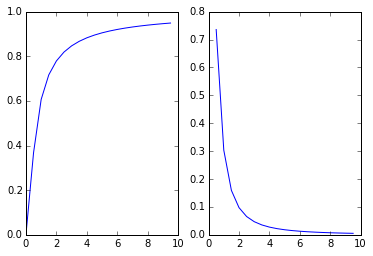

In [197]:
plt.subplot(121)
adis = 1
sigma_i_dis = np.arange(0,10,.5)
plt.plot(sigma_i_dis,np.exp(-adis**2/(2*sigma_i_dis)))

plt.subplot(122)

y = np.array([f(adis,s).sum() for s in sigma_i_dis])
plt.plot(sigma_i_dis,y)

In [2]:
sigma_i = T.dscalar('sigma_i')
mu = 0
examp = T.dvector('examp')
ex = T.dscalar('ex')
a = T.dscalar('a')

mynorm = ((2*np.pi*sigma_i**2)**-.5)*T.exp(-(ex-mu)**2/(2*sigma_i**2))
fnorm = theano.function([ex,sigma_i], mynorm)
L = T.prod(((2*np.pi*sigma_i**2)**-.5)*T.exp(-(examp-mu)**2/(2*sigma_i**2)))
fL = theano.function([examp,sigma_i], L)
LL = T.sum(T.log((((2*np.pi*sigma_i**2)**-.5)*T.exp(-(examp-mu)**2/(2*sigma_i**2)))))
fLL = theano.function([examp,sigma_i], LL)
LL2 = T.sum(-.5*T.log((((2*np.pi*sigma_i**2)))) -(examp-mu)**2/(2*sigma_i**2))
fLL2 = theano.function([examp,sigma_i], LL2)
NLL = -T.sum(-.5*T.log((((2*np.pi*sigma_i**2)))) -(examp-mu)**2/(2*sigma_i**2))
fNLL = theano.function([examp,sigma_i], NLL)

'''
LLsigi = T.sum(-.5*T.log(2*np.pi*sigma_i**2)) - T.sum(-(examp-mu)**2)/(2*sigma_i**2)) #need to look into T.elemwise
gLLsigi = T.grad(LLsigi,sigma_i)
fLLsigi = theano.function([examp,sigma_i], LLsigi)
fgLLsigi = theano.function([examp,sigma_i], gLLsigi)
pp(fLLsigi.maker.fgraph.outputs[0])
'''


'\nLLsigi = T.sum(-.5*T.log(2*np.pi*sigma_i**2)) - T.sum(-(examp-mu)**2)/(2*sigma_i**2)) #need to look into T.elemwise\ngLLsigi = T.grad(LLsigi,sigma_i)\nfLLsigi = theano.function([examp,sigma_i], LLsigi)\nfgLLsigi = theano.function([examp,sigma_i], gLLsigi)\npp(fLLsigi.maker.fgraph.outputs[0])\n'

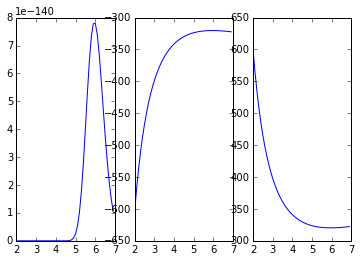

In [3]:
#y = np.array([fnorm(e,5).sum() for e in examples])
#plt.scatter(examples,y)
sigis = np.arange(2,7,.1)
plt.subplot(131)
yL = np.array([fL(examples,s) for s in sigis])
plt.plot(sigis,yL)
plt.subplot(132)
yLL = np.array([fLL(examples,s) for s in sigis])
plt.plot(sigis,yLL)
plt.subplot(133)
yLL2 = np.array([fNLL(examples,s) for s in sigis])
plt.plot(sigis,yLL2)

In [56]:


s = theano.shared(np.array(10, dtype=theano.config.floatX))
print s.get_value()
NLL = -T.sum(-.5*T.log((((2*np.pi*sigma_i**2)))) -(examp-mu)**2/(2*sigma_i**2))

NLLs = -T.sum(-.5*T.log((((2*np.pi*s**2)))) -(examp-mu)**2/(2*s**2))

fNLL = theano.function([examp,sigma_i], NLL)
fNLLs = theano.function([examp], NLLs)
T.grad(NLLs,s)

#T.grad(NLLs,s)

def grad_desc(cost=NLLs,param=s ,momentum = .5,learning_rate = .5):
    updates=[]
    param_update = theano.shared(param.get_value())
    updates.append((param, param - learning_rate*param_update))
    updates.append((param_update, momentum*param_update + (1. - momentum) * T.grad(cost, param)))
    return updates

train = theano.function([examp], NLLs, updates=grad_desc())
#updates=grad_desc())
#updates = grad_desc()

10.0


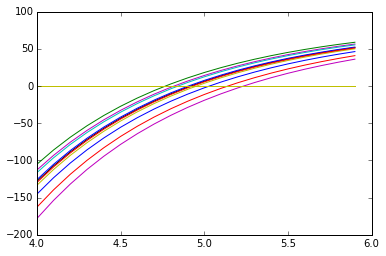

In [103]:
gNLLs = T.grad(NLLs,s)
fNLLs = theano.function([examp],NLLs)
fgNLLs = theano.function([examp],gNLLs)
X = np.arange(4,6,.1)

for _ in range(10):
    examples = np.random.normal(loc=0, scale=5.0, size=1000) #scale is the standard deviation
    vals = []
    g_vals = []
    for x in X:
        s.set_value(x)
        vals.append(fNLLs(examples))
        g_vals.append(fgNLLs(examples))
    plt.plot(X,g_vals)
    plt.plot(hold=True)
    plt.plot(X,np.zeros(np.shape(X)))


In [405]:
layer_sizes = [X.shape[0], X.shape[0]*2, 1]
# Set initial parameter values
W_init = []
b_init = []
activations = []
for n_input, n_output in zip(layer_sizes[:-1], layer_sizes[1:]):
    # Getting the correct initialization matters a lot for non-toy problems.
    # However, here we can just use the following initialization with success:
    # Normally distribute initial weights
    W_init.append(np.random.randn(n_output, n_input))
    # Set initial biases to 1
    b_init.append(np.ones(n_output))
    # We'll use sigmoid activation for all layers
    # Note that this doesn't make a ton of sense when using squared distance
    # because the sigmoid function is bounded on [0, 1].
    activations.append(T.nnet.sigmoid)
# Create an instance of the MLP class
mlp = MLP(W_init, b_init, activations)

NameError: name 'MLP' is not defined

------

In [274]:
N = 400
feats = 784
D = (rng.randn(N, feats), rng.randint(size=N,low=0, high=2))
training_steps = 10000
rng = np.random
x = T.matrix("x")
y = T.vector("y")
w = theano.shared(rng.randn(100), name="w")
b = theano.shared(0., name="b")
print "Initial model:"
print w.get_value(), b.get_value()


Initial model:
[ 0.45164588  1.18856232 -0.92563873 -0.80879455  0.04894855 -1.47913839
 -1.11994857 -0.52380558  0.49745601  0.58708772  0.2446972   0.18714491
 -1.64172929 -0.13297112 -0.97159792  1.50947668 -1.05265836  0.01239463
 -0.28245709 -0.75697939  0.84056295  0.22199855 -0.11868983  1.25965298
  1.87679289  0.69519864  0.86535598  0.44894683  1.29065809  0.76532764
 -1.54788764  0.43768358 -1.03371643 -1.51791771  1.16231199 -1.3847705
  0.61734257  1.09071116  0.73673701  1.39019807 -0.16697507 -0.64172992
 -0.01001874  1.14404785 -0.86363038  0.48285194  1.46530818  0.91464165
 -0.04844964  0.53022974  0.663406   -0.9035858  -0.74747061 -0.28507281
  0.30727723 -0.09222686  0.26283866  0.99320985  0.76962232  0.61929311
  2.4732952   1.13151441  0.39344522  0.78765972 -0.0234243   0.17001148
  1.29836978 -0.53071164 -0.37632322 -1.37538872 -0.8104712   0.09890733
 -0.04104758  0.96411426  1.34651037 -0.03003724  2.15828615 -0.40597065
 -0.12188884  0.5319623  -1.19296861 

In [276]:
x = T.matrix("x")
y = T.vector("y")
w = theano.shared(rng.randn(100), name="w")
b = theano.shared(0., name="b")
# Construct Theano expression graph
p_1 = 1 / (1 + T.exp(-T.dot(x, w)-b)) # Probability that target = 1
prediction = p_1 > 0.5 # The prediction thresholded
xent = -y*T.log(p_1) - (1-y)*T.log(1-p_1)# Cross-entropy loss function
cost = xent.mean() + 0.01*(w**2).sum() # The cost to minimize
gw,gb = T.grad(cost, [w,b])

In [283]:
x = T.matrix("x")
y = T.vector("y")
w = theano.shared(rng.randn(100), name="w")
b = theano.shared(0., name="b")
p_1 = 1 / (1 + T.exp(-T.dot(x, w)-b))
prediction = p_1 > 0.5
xent = -y*T.log(p_1) - (1-y)*T.log(1-p_1)
cost = xent.mean() + 0.01*(w**2).sum()
gw,gb = T.grad(cost, [w,b])
# Compile
train = theano.function(
inputs=[x,y],
outputs=[prediction, xent],
updates= OrderedDict({w:w-0.1*gw, b:b-0.1*gb}))
predict = theano.function(inputs=[x], outputs=prediction)

In [285]:
for i in range(training_steps):
    pred, err = train(D[0], D[1])
print "Final model:"
print w.get_value(), b.get_value()
print "target values for D:", D[1]
print "prediction on D:", predict(D[0])

ValueError: Shape mismatch: A.shape[1] != y.shape[0]
Apply node that caused the error: CGemv{inplace}(Alloc.0, TensorConstant{1.0}, x, w, TensorConstant{0.0})
Inputs types: [TensorType(float64, vector), TensorType(float64, scalar), TensorType(float64, matrix), TensorType(float64, vector), TensorType(float64, scalar)]
Inputs shapes: [(400,), (), (400, 784), (100,), ()]
Inputs strides: [(8,), (), (6272, 8), (8,), ()]
Inputs values: ['not shown', array(1.0), 'not shown', 'not shown', array(0.0)]

HINT: Re-running with most Theano optimization disabled could give you a back-trace of when this node was created. This can be done with by setting the Theano flag 'optimizer=fast_compile'. If that does not work, Theano optimizations can be disabled with 'optimizer=None'.
HINT: Use the Theano flag 'exception_verbosity=high' for a debugprint and storage map footprint of this apply node.